In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde
import dynesty as dyn

In [2]:
data = pd.read_csv('1612.tsv', sep='\t', header=None)

x = (data[1].values + data[0].values)/2.0
y = data[2].values
yerr = data[3].values

16405it [02:02, 134.19it/s, +1024 | bound: 83 | nc: 1 | ncall: 320402 | eff(%):  5.457 | loglstar:   -inf < -27.468 <    inf | logz: -36.572 +/-  0.089 | dlogz:  0.000 >  0.001]
23073it [03:03, 125.42it/s, +1024 | bound: 130 | nc: 1 | ncall: 485346 | eff(%):  4.975 | loglstar:   -inf < -21.174 <    inf | logz: -36.787 +/-    nan | dlogz:  0.000 >  0.001]
23123it [03:09, 121.84it/s, +1024 | bound: 130 | nc: 1 | ncall: 486777 | eff(%):  4.971 | loglstar:   -inf < -19.045 <    inf | logz: -34.707 +/-    nan | dlogz:  0.000 >  0.001]


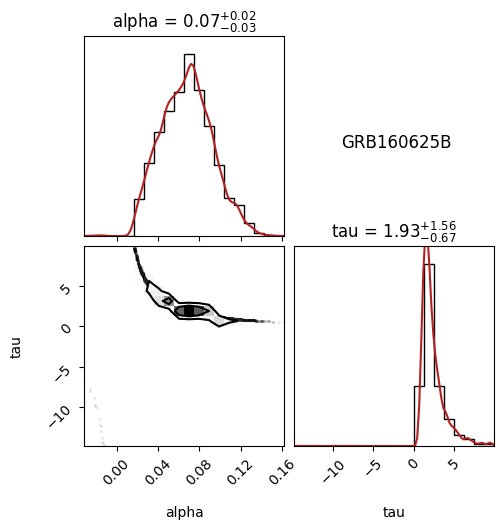

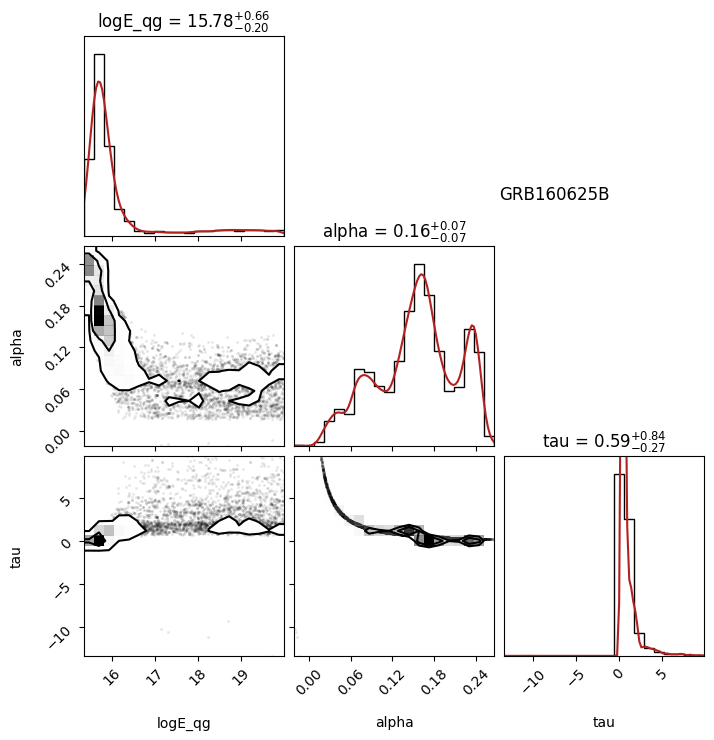

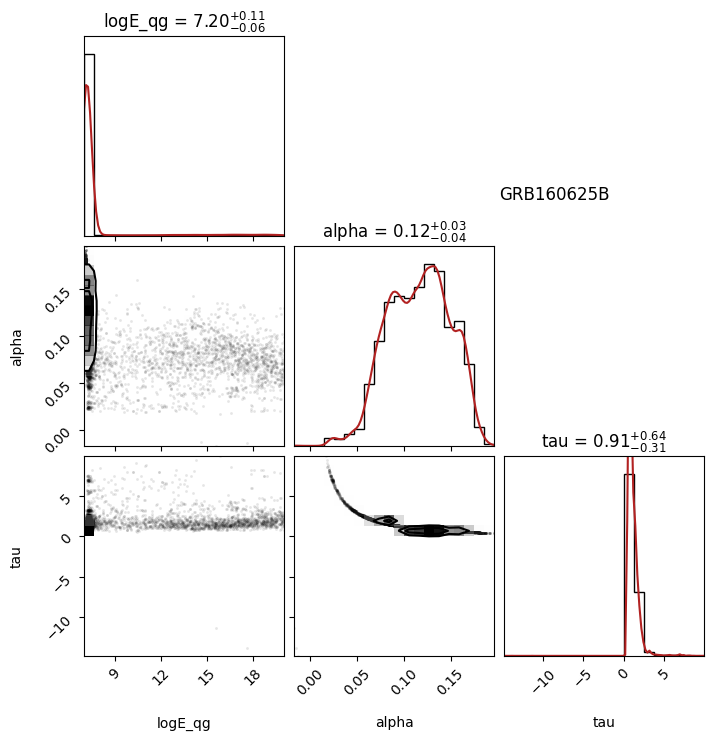

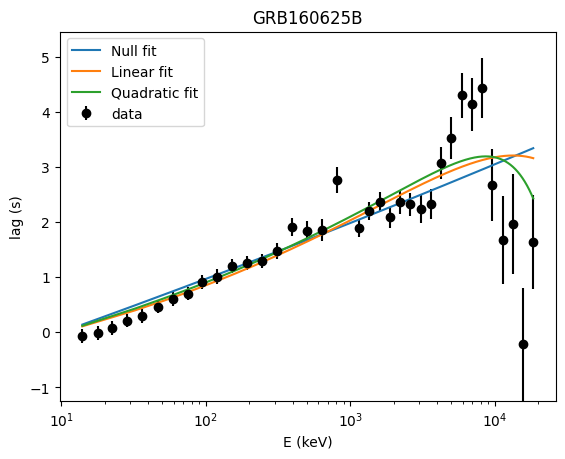

In [3]:
ncpu=12
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)
grb = 'GRB160625B'
grbname = grb + '.txt'
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = x    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
H0=67.36 #Hubble constant km -1 Mpc s -1
omega_m = 0.315
omega_l = 1 - omega_m
lin_conv_fac = 3.0856 * 10**13
quad_conv_fac = 3.0856 * 10**7
arr_o = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)    
xo = arr_o[:,0]
yo = arr_o[:,1]
yoerr = arr_o[:,2]




#MODELS

#NULL model
def nullhp(E, alpha, tau):
    return (1 + z_com)*(tau * ((E ** alpha) - (E0 ** alpha)))
    


def int_z(z_prime, n):
    integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
    return quad( integ_fn, a=0, b=z_prime)[0]

int_z1 = np.asarray(int_z(z_com, 1))
int_z2 = np.asarray(int_z(z_com, 2))

#LINEAR model
def linearhp(E, logEqg, alpha, tau):
    
    e0qg = (E - E0) / (10 ** logEqg)
    
    return - (lin_conv_fac * e0qg * int_z1)/H0 + nullhp(E, alpha, tau)

#QUADRATIC model
def quadhp(E, logEqg, alpha, tau):
    e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
    
    return -1.5 * (quad_conv_fac * e0qg * int_z2)/H0 + nullhp(E, alpha, tau)


#LOG-LIKELIHOODS
def loglike_null(theta):
    alpha, tau = theta
    
    
    model = nullhp(x,  alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    

def loglike_linear(theta):
    logEqg, alpha, tau = theta
    
    model = linearhp(x, logEqg, alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))

def loglike_quad(theta):
    logEqg, alpha, tau = theta
    
    model = quadhp(x, logEqg, alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))


#PRIORS

alphamin = -2
alphamax = 1
taumin = -15
taumax = 10
logeqmin = 0
logeqmax = 20


#PRIOR DISTRIBUTIONS

def prior_transform_null(theta):
    alpha, tau = theta
    return [(alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

def prior_transform_linear(theta):
    logEqg, alpha, tau = theta
    return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

def prior_transform_quadratic(theta):
    logEqg, alpha, tau = theta
    return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]


#SAMPLING
nlive = 1024

with dyn.pool.Pool(ncpu, loglike_null, prior_transform_null) as pool0:
    sampler0 = dyn.NestedSampler(loglike_null, prior_transform_null, ndim=2, nlive = nlive, sample='rwalk', bound='multi', pool=pool0)
    sampler0.run_nested(dlogz=0.001)
    # sampler0.save(os.getcwd() + '/outputs/sampler_saves/' + grbname_wtht_ext + '_null_sampler.dill', store_samples=True)


with dyn.pool.Pool(ncpu, loglike_linear, prior_transform_linear) as pool1:
    sampler1 = dyn.NestedSampler(loglike_linear, prior_transform_linear, ndim=3, nlive = nlive, sample='rwalk', bound='multi', pool=pool1)
    sampler1.run_nested(dlogz=0.001)


with dyn.pool.Pool(ncpu, loglike_quad, prior_transform_quadratic) as pool2:
    sampler2 = dyn.NestedSampler(loglike_quad, prior_transform_quadratic, ndim=3, nlive = nlive, sample='rwalk', bound='multi', pool=pool2)
    sampler2.run_nested(dlogz=0.001)


results0 = sampler0.results
results1 = sampler1.results
results2 = sampler2.results


def smooth_plot(results, figname, labels=["logE_qg", 'alpha', 'tau']):
        weights = np.exp(results.logwt - results.logz[-1])
        samples = dyn.utils.resample_equal(  results.samples, weights)
        
        fig = corner(samples, weights=weights, labels=labels, levels=[0.68, 0.9], show_titles=True, title_kwargs={"fontsize": 12}, hist_kwargs={'density': True})
        ndim =samples.shape[1]
        for axidx, samps in zip([i*(ndim+1) for i in range(ndim)],samples.T):
            kde = gaussian_kde(samps)
            xvals = fig.axes[axidx].get_xlim()
            xvals = np.linspace(xvals[0], xvals[1], 100)
            fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
            
        # plt.title(str(grb) + '\n\n')
        plt.suptitle(str(grb) + '\n\n', x=0.75, y=0.75)
        plt.show()
        # plt.savefig(os.getcwd() + '/outputs/contours/' + grb + '_' + figname + '.png')


smooth_plot(results0, 'nullhp', labels=["alpha", 'tau'])


smooth_plot(results1, 'linearhp')


smooth_plot(results2, 'quadhp')


#PLOTTING FITS

nplot = 1000
E = np.linspace(min(Erest), max(Erest), nplot)
samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
# samples0 = np.median(samples0, axis=0)
samples0 = samples0[np.argmax(results0.logl)]

samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
# samples1 = np.median(samples1, axis=0)
samples1 = samples1[np.argmax(results1.logl)]

samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
# samples2 = np.median(samples2, axis=0)
samples2 = samples2[np.argmax(results2.logl)]
null_fit = [nullhp(E[i], samples0[0], samples0[1]) for i in range(nplot)]
liv_lin_fit = [linearhp(E[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]
liv_quad_fit = [quadhp(E[i], samples2[0], samples2[1], samples2[2]) for i in range(nplot)]

plt.figure()
plt.errorbar(x, y, yerr, fmt='o', color='black', label='data')
plt.plot(E, null_fit, label='Null fit')
plt.plot(E, liv_lin_fit,label='Linear fit')
plt.plot(E, liv_quad_fit, label='Quadratic fit')
plt.xscale('log')
# plt.yscale('log')
plt.ylim(min(y) - max(abs(yerr)), max(y) + max(abs(yerr)))
# plt.ylim(-200, 20)
plt.legend()
plt.xlabel('E (keV)')
plt.ylabel('lag (s)')
plt.title(grb)
# plt.savefig(os.getcwd() + '/outputs/fits/' + grb + '_fit_logE.png', facecolor='white')
plt.show()

In [4]:
threesamplers = ['_null_sampler.pkl', '_linear_sampler.pkl', '_quadratic_sampler.pkl']
sampler0_o = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[0])
sampler1_o = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[1])
sampler2_o = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[2])
results0_o = sampler0_o.results
results1_o = sampler1_o.results
results2_o = sampler2_o.results

#PLOTTING FITS

nplot = 1000
E_o = np.linspace(min(Erest), max(Erest), nplot)
samples0_o = dyn.utils.resample_equal( results0_o.samples, np.exp(results0_o.logwt - results0_o.logz[-1]))
# samples0 = np.median(samples0, axis=0)
samples0_o = samples0_o[np.argmax(results0_o.logl)]

samples1_o = dyn.utils.resample_equal( results1_o.samples, np.exp(results1_o.logwt - results1_o.logz[-1]))
# samples1 = np.median(samples1, axis=0)
samples1_o = samples1_o[np.argmax(results1_o.logl)]

samples2_o = dyn.utils.resample_equal( results2_o.samples, np.exp(results2_o.logwt - results2_o.logz[-1]))
# samples2 = np.median(samples2, axis=0)
samples2_o = samples2_o[np.argmax(results2_o.logl)]
null_fit_o = [nullhp(E_o[i], samples0_o[0], samples0_o[1]) for i in range(nplot)]
liv_lin_fit_o = [linearhp(E_o[i], samples1_o[0], samples1_o[1], samples1_o[2]) for i in range(nplot)]
liv_quad_fit_o = [quadhp(E_o[i], samples2_o[0], samples2_o[1], samples2_o[2]) for i in range(nplot)]

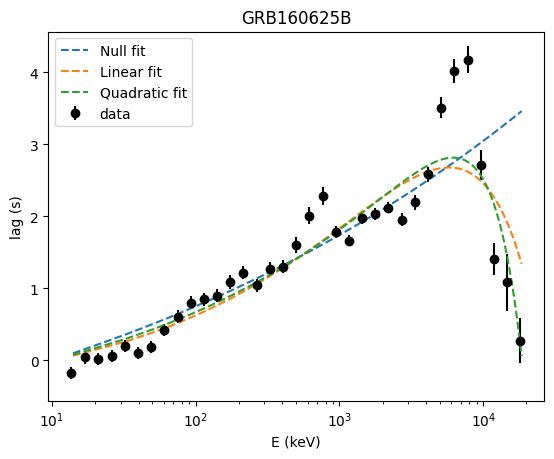

In [9]:
plt.figure()
plt.errorbar(xo, yo, yoerr, fmt='o', color='black', label='data')
plt.plot(E_o, null_fit_o, label='Null fit', ls = '--')
plt.plot(E_o, liv_lin_fit_o,label='Linear fit', ls = '--')
plt.plot(E_o, liv_quad_fit_o, label='Quadratic fit', ls = '--')
plt.xscale('log')
# plt.yscale('log')
plt.ylim(min(yo) - max(abs(yoerr)), max(yo) + max(abs(yoerr)))
# plt.ylim(-200, 20)
plt.legend()
plt.xlabel('E (keV)')
plt.ylabel('lag (s)')
plt.title(grb)
# plt.savefig(os.getcwd() + '/outputs/fits/' + grb + '_fit_logE.png', facecolor='white')
plt.show()

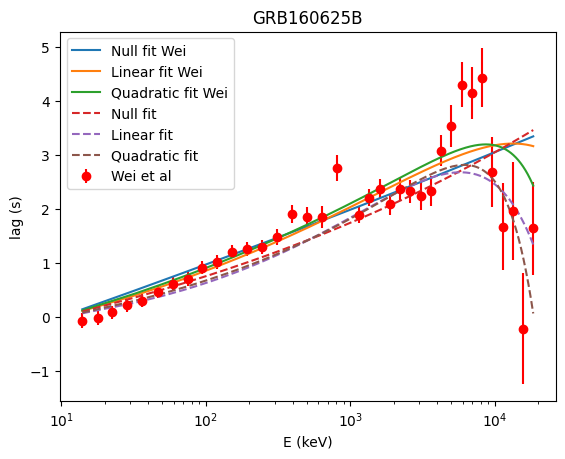

In [21]:
# plt.errorbar(xo, yo, yoerr, fmt='o', color='black', label='data')
plt.errorbar(x, y, yerr, fmt='o', color='red', label='Wei et al')

plt.plot(E, null_fit, label='Null fit Wei')
plt.plot(E, liv_lin_fit,label='Linear fit Wei')
plt.plot(E, liv_quad_fit, label='Quadratic fit Wei')

plt.plot(E_o, null_fit_o, label='Null fit', ls = '--')
plt.plot(E_o, liv_lin_fit_o,label='Linear fit', ls = '--')
plt.plot(E_o, liv_quad_fit_o, label='Quadratic fit', ls = '--')
plt.xscale('log')
plt.legend()
plt.xlabel('E (keV)')
plt.ylabel('lag (s)')
plt.title(grb)
plt.show()

In [16]:
def chi2_gof(x, y, yerr, fit_func, *fit_func_args):
        return np.sum(((y - fit_func(x, *fit_func_args))/yerr)**2)/(len(y) - len(fit_func_args))


gof_null = chi2_gof(x, y, yerr, nullhp, samples0[0], samples0[1])
gof_lin = chi2_gof(x, y, yerr, linearhp, samples1[0], samples1[1], samples1[2])
gof_quad = chi2_gof(x, y, yerr, quadhp, samples2[0], samples2[1], samples2[2])


In [17]:
print(gof_null)
print(gof_lin)
print(gof_quad)

2.984629713574228
2.683756714913173
2.527875947776547


In [19]:
gof_null_o = chi2_gof(xo, yo, yoerr, nullhp, samples0_o[0], samples0_o[1])
gof_lin_o = chi2_gof(xo, yo, yoerr, linearhp, samples1_o[0], samples1_o[1], samples1_o[2])
gof_quad_o = chi2_gof(xo, yo, yoerr, quadhp, samples2_o[0], samples2_o[1], samples2_o[2])

In [20]:
print(gof_null_o)
print(gof_lin_o)
print(gof_quad_o)

14.581202962074766
11.524259932420865
10.051453850503648
